# Benchmarking of two pass method:

In this notebook we will plot the figures showing the benchmarking analyses for the two pass method compared to one pass as a negative control, and reference guided alignment as a positive control. The data here is only for simulated Arabidopsis and human reads

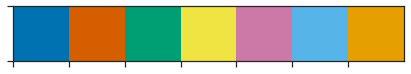

In [1]:
import sys
import re
from collections import Counter
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import display_markdown, display

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
USESAMPLES = [
    'firstpass', 'nofilt', 'dt1filt', 'dt2filt', 'flair_corrected', 'refguided'
]

def read_splice_assignments(tsv_fn):
    res = Counter()
    with open(tsv_fn) as f:
        for line in f:
            read_id, classi = line.split()
            res[int(classi)] += 1
    return res


def get_sim_dataset_splice_assignments(basedir, usesamples=USESAMPLES):
    res = []
    for fn in glob(f'../{basedir}/*/metrics/*.sim_nofrag.*.tsv'):
        if 'quant' in fn:
            continue
        sample_name, sample_type = re.search('metrics/(.+?)\.sim_nofrag\.(.+?)\.tsv$', fn).groups()
        if not sample_type in usesamples:
            continue
        r = read_splice_assignments(fn)
        res.append([sample_name, sample_type, r[0], r[1], r[2]])

    res = pd.DataFrame(
        res,
        columns=['dataset', 'method',
                 'unannot', 'annot_correct', 'annot_incorrect']
    )
    res_melt = pd.melt(
        res,
        id_vars=['dataset', 'method'],
        value_vars=['unannot', 'annot_correct', 'annot_incorrect'],
        var_name='aln_cat',
        value_name='freq'
    )
    res_melt = (res_melt.groupby(['dataset', 'method'], as_index=False)
                        .apply(lambda x: x.assign(norm_freq=x.freq / sum(x.freq) * 100))
                        .reset_index(drop=True))
    return res_melt


def get_sim_dataset_quant_res(basename, usesamples=USESAMPLES, is_ensembl=False):
    quant_res = []
    for gt_fn in glob(f'../{basename}/*/simulated_data/*_quant.tsv'):
        gt_counts = pd.read_csv(
            gt_fn,
            sep='\t',
            names=['transcript_id', 'gt_count']
        )
        if is_ensembl:
            gt_counts.transcript_id = gt_counts.transcript_id.str.split('.', expand=True)[0]
        sample_name = re.search(f'{basename}/(.+?)/simulated_data', gt_fn).group(1)
        for fn in glob(f'../{basename}/{sample_name}/metrics/*.sim_nofrag.*.quant.tsv'):
            sample_type = re.search('sim_nofrag\.(.+?)\.quant\.tsv$', fn).group(1)
            counts = pd.read_csv(fn, sep='\t', names=['transcript_id', 'pred_count'])
            counts = gt_counts.merge(counts, on='transcript_id', how='left').fillna(0)
            pearsonr = stats.pearsonr(counts.gt_count, counts.pred_count)[0]
            spearmanr = stats.spearmanr(counts.gt_count, counts.pred_count)[0]
            quant_res.append([sample_name, sample_type, pearsonr, spearmanr])
    quant_res = pd.DataFrame(
        quant_res,
        columns=['dataset', 'method', 'pearsonr', 'spearmanr']
    )
    return quant_res

In [3]:
arath_aln_stats = get_sim_dataset_splice_assignments('arabidopsis_drs')
human_aln_stats = get_sim_dataset_splice_assignments('human_drs')

arath_quant_res = get_sim_dataset_quant_res('arabidopsis_drs')
human_quant_res = get_sim_dataset_quant_res('human_drs', is_ensembl=True)

In [30]:
DEFAULT_BOXPLOT_KWARGS = {'color': '#eeeeee', 'fliersize': 0, 'width': 0.8}
DEFAULT_STRIPPLOT_KWARGS = {'jitter': 0.2, 'color': pal[0], 'size': 8, 'dodge': True}


def boxplot_with_overlaid_stripplot(*, x, y, hue=None, data=None,
                                    order=None, strip_hue=None,
                                    boxplot_kwargs=None,
                                    stripplot_kwargs=None,
                                    ax=None):
    if boxplot_kwargs is None:
        boxplot_kwargs = DEFAULT_BOXPLOT_KWARGS
    else:
        boxplot_kwargs = dict(DEFAULT_BOXPLOT_KWARGS, **boxplot_kwargs)

    if stripplot_kwargs is None:
        stripplot_kwargs = DEFAULT_STRIPPLOT_KWARGS
    else:
        stripplot_kwargs = dict(DEFAULT_STRIPPLOT_KWARGS, **stripplot_kwargs)

    ax = sns.boxplot(
        x=x,
        y=y,
        data=data,
        hue=hue,
        order=order,
        ax=ax,
        **boxplot_kwargs
    )

    ax = sns.stripplot(
        x=x,
        y=y,
        data=data,
        hue=strip_hue if strip_hue is not None else hue,
        order=order,
        ax=ax,
        **stripplot_kwargs
    )

    return ax


def plot_correctly_aligned_reads_arath_human(order, labels):
    fig, axes = plt.subplots(figsize=(10, 5.5), ncols=2, sharey=True)
    boxplot_with_overlaid_stripplot(
        x='method',
        y='norm_freq',
        data=arath_aln_stats.query('aln_cat == "annot_correct"'),
        ax=axes[0],
        order=order
    )

    boxplot_with_overlaid_stripplot(
        x='method',
        y='norm_freq',
        data=human_aln_stats.query('aln_cat == "annot_correct"'),
        ax=axes[1],
        order=order
    )

    axes[0].set_xlabel('')
    axes[1].set_xlabel('')
    axes[0].set_ylabel('Correctly aligned reads (%)')
    axes[1].set_ylabel('')
    axes[0].set_xticklabels(
        labels,
        rotation=30,
        ha='right'
    )
    axes[1].set_xticklabels(
        labels,
        rotation=30,
        ha='right'
    )
    axes[0].set_title('Arabidopsis\n(TAIR10 + AtRTD2 reference)')
    axes[1].set_title('Human (GRCh38 reference)')
    plt.tight_layout()
    return axes


def plot_incorrectly_aligned_reads_arath_human(order, labels):
    fig, axes = plt.subplots(figsize=(10, 5.5), ncols=2, sharey=True)

    boxplot_with_overlaid_stripplot(
        x='method',
        y='norm_freq',
        hue='aln_cat',
        data=arath_aln_stats.query('aln_cat != "annot_correct"'),
        ax=axes[0],
        order=order,
        stripplot_kwargs={'color': None, 'palette': pal[1:]}
    )

    boxplot_with_overlaid_stripplot(
        x='method',
        y='norm_freq',
        hue='aln_cat',
        data=human_aln_stats.query('aln_cat != "annot_correct"'),
        ax=axes[1],
        order=order,
        stripplot_kwargs={'color': None, 'palette': pal[1:]}
    )

    axes[0].set_xlabel('')
    axes[1].set_xlabel('')
    axes[0].set_ylabel('Incorrectly aligned reads (%)')
    axes[1].set_ylabel('')
    axes[0].set_xticklabels(
        labels,
        rotation=30,
        ha='right'
    )
    axes[1].set_xticklabels(
        labels,
        rotation=30,
        ha='right'
    )
    axes[0].set_title('Arabidopsis\n(TAIR10 + AtRTD2 reference)')
    axes[1].set_title('Human (GRCh38 reference)')


    axes[0].legend_.remove()

    dh1 = axes[0].scatter([], [], color=pal[1], s=35)
    dh2 = axes[0].scatter([], [], color=pal[2], s=35)

    axes[1].legend_ = plt.legend([dh1, dh2], ['Not in annot.', 'Incorrect annot.\ntranscipt'])

    plt.tight_layout()
    return axes

### FLAIR correction vs. minimap2 reference guided alignment:

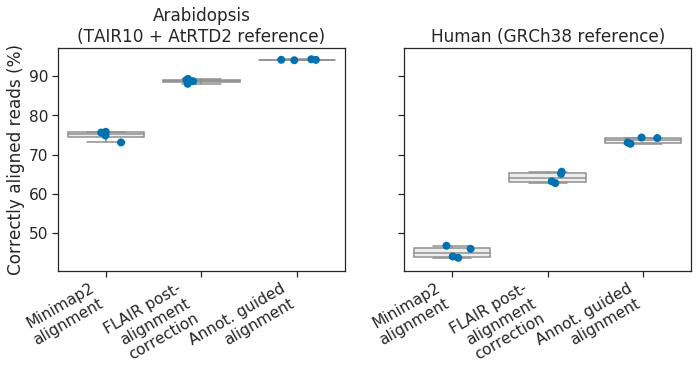

In [31]:
plot_correctly_aligned_reads_arath_human(
    ['firstpass', 'flair_corrected', 'refguided'],
    ['Minimap2\nalignment', 'FLAIR post-\nalignment\ncorrection', 'Annot. guided\nalignment'],
)
plt.savefig('figures/correct_percentage_flair.svg')
plt.show()

Basically this shows that it is better to do reference guided alignment than post-alignment correction to the reference, if you do have a reference to use. My expectation would be that this also holds true for using Illumina reads to produce high confidence junctions.

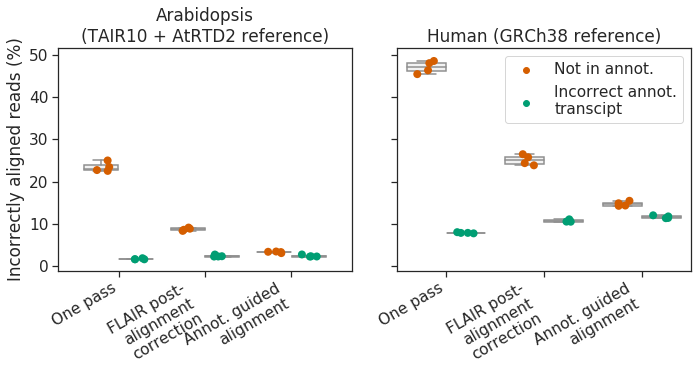

In [32]:
plot_incorrectly_aligned_reads_arath_human(
    ['firstpass', 'flair_corrected', 'refguided'],
    ['One pass', 'FLAIR post-\nalignment\ncorrection', 'Annot. guided\nalignment'],
)
plt.savefig('figures/incorrect_percentage_flair.svg')
plt.show()

Interestingly there is a slight increase in the number of reads which align to the wrong reference transcript when you provide the reference annotation as a guide (or do post-alignment correction with FLAIR). This may affect the transcript level quantification of some genes.

### Two pass alignment - no filtering of junctions:

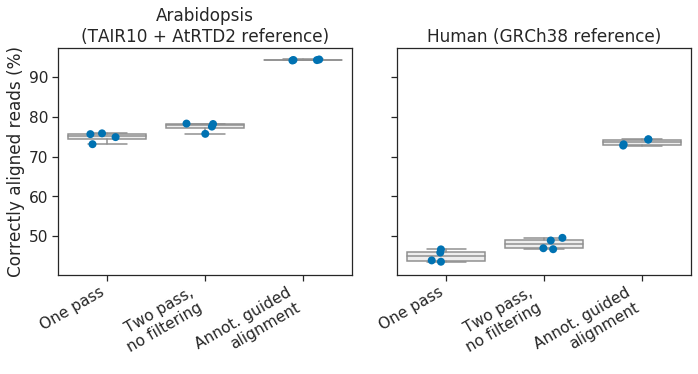

In [33]:
plot_correctly_aligned_reads_arath_human(
    ['firstpass', 'nofilt', 'refguided'],
    ['One pass', 'Two pass,\nno filtering', 'Annot. guided\nalignment'],
)
plt.savefig('figures/correct_percentage_naive_2pass.svg')
plt.show()

We see a very slight improvement in correctly aligned reads with a naive two pass method.

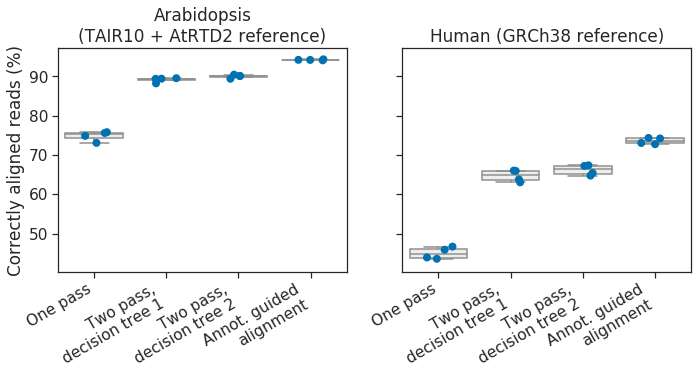

In [34]:
plot_correctly_aligned_reads_arath_human(
    ['firstpass', 'dt1filt', 'dt2filt', 'refguided'],
    ['One pass', 'Two pass,\ndecision tree 1', 'Two pass,\ndecision tree 2', 'Annot. guided\nalignment'],
)
plt.savefig('figures/correct_percentage_filtered_2pass.svg')
plt.show()

Using a filtered two pass method, we can improve the alignment of nanopore DRS reads greatly. For the simulated datasets, two pass actually outperforms FLAIR despite FLAIR correcting the data using the reference!

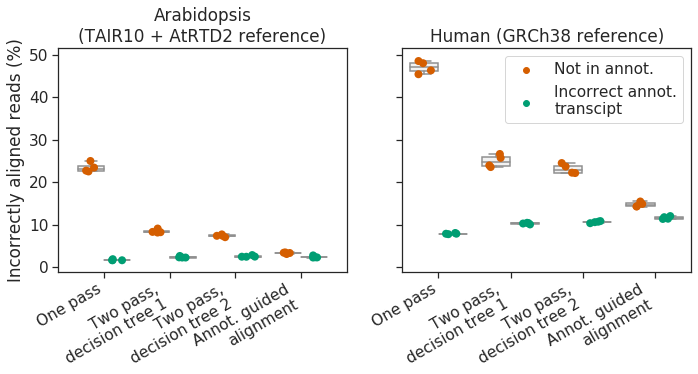

In [35]:
plot_incorrectly_aligned_reads_arath_human(
    ['firstpass', 'dt1filt', 'dt2filt', 'refguided'],
    ['One pass', 'Two pass,\ndecision tree 1', 'Two pass,\ndecision tree 2', 'Annot. guided\nalignment'],
)
plt.savefig('figures/incorrect_percentage_filtered_2pass.svg')
plt.show()

A downside of the two pass method is that we do see an increase in the number of reads mapping to the incorrect reference transcript, which may affect the quantification of these transcripts.

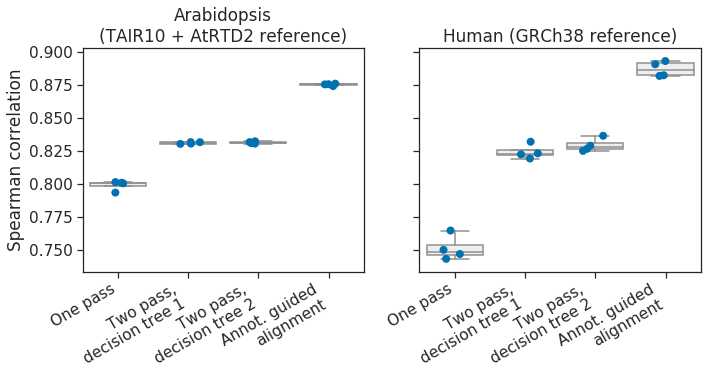

In [49]:
fig, axes = plt.subplots(figsize=(10, 5.5), ncols=2, sharey=True)

boxplot_with_overlaid_stripplot(
    x='method',
    y='spearmanr',
    data=arath_quant_res,
    ax=axes[0],
    order=['firstpass', 'dt1filt', 'dt2filt', 'refguided'],
)

boxplot_with_overlaid_stripplot(
    x='method',
    y='spearmanr',
    data=human_quant_res,
    ax=axes[1],
    order=['firstpass', 'dt1filt', 'dt2filt', 'refguided'],
)

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].set_ylabel('Spearman correlation')
axes[1].set_ylabel('')
axes[0].set_xticklabels(
    ['One pass', 'Two pass,\ndecision tree 1', 'Two pass,\ndecision tree 2', 'Annot. guided\nalignment'],
    rotation=30,
    ha='right'
)
axes[1].set_xticklabels(
    ['One pass', 'Two pass,\ndecision tree 1', 'Two pass,\ndecision tree 2', 'Annot. guided\nalignment'],
    rotation=30,
    ha='right'
)
axes[0].set_title('Arabidopsis\n(TAIR10 + AtRTD2 reference)')
axes[1].set_title('Human (GRCh38 reference)')

plt.tight_layout()
plt.savefig('figures/quantification_spearmanr_filtered_2pass.svg')
plt.show()

In [60]:
human_quant_res[human_quant_res.method.isin(['firstpass', 'dt1filt', 'dt2filt', 'refguided'])].groupby('method').spearmanr.median()

method
dt1filt      0.822980
dt2filt      0.827994
firstpass    0.748770
refguided    0.886634
Name: spearmanr, dtype: float64

Despite this we see that the correlation of simulated counts and the counts retrieved by alignment are improved after two pass alignment, suggesting that overall this misalignment has a small effect.

### Overall statistics:

In [11]:
def display_median(dataset, aln_cat, label):
    df = pd.DataFrame(dataset.query(f'aln_cat == "{aln_cat}"').groupby('method').norm_freq.median())
    display_markdown(f'#### {label}:\n', raw=True)
    display(df)

display_median(arath_aln_stats, 'annot_correct', 'Median correct Arabidopsis')
display_median(human_aln_stats, 'annot_correct', 'Median correct human')
display_median(arath_aln_stats, 'annot_incorrect', 'Median incorrect annot. transcript Arabidopsis')
display_median(human_aln_stats, 'annot_incorrect', 'Median incorrect annot. transcript human')

#### Median correct Arabidopsis:


,norm_freq
method,
dt1filt,89.407852
dt2filt,90.118085
firstpass,75.248558
flair_corrected,88.901519
nofilt,77.834285
refguided,94.202990


#### Median correct human:


,norm_freq
method,
dt1filt,64.893603
dt2filt,66.342270
firstpass,44.940825
flair_corrected,64.121252
nofilt,47.974999
refguided,73.647656


#### Median incorrect annot. transcript Arabidopsis:


,norm_freq
method,
dt1filt,2.311713
dt2filt,2.496426
firstpass,1.665299
flair_corrected,2.347415
nofilt,1.697526
refguided,2.338933


#### Median incorrect annot. transcript human:


,norm_freq
method,
dt1filt,10.337649
dt2filt,10.662729
firstpass,7.889339
flair_corrected,10.684665
nofilt,8.342704
refguided,11.599567
